In [1]:
import numpy as np
import pandas as pd
from os.path import join

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, fhmm_exact
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days


## Loading data

In [2]:
we = DataSet('/Users/nipunbatra/wikienergy-2.h5')
print('loaded ' + str(len(we.buildings)) + ' buildings')

loaded 239 buildings


In [3]:
building_number = 1
print_dict(we.buildings[building_number].metadata)

In [4]:
elec = we.buildings[building_number].elec
elec.appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='fridge', instance=2),
 Appliance(type='light', instance=1),
 Appliance(type='light', instance=2),
 Appliance(type='electric vehicle', instance=1),
 Appliance(type='electric furnace', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='oven', instance=2),
 Appliance(type='waste disposal unit', instance=1),
 Appliance(type='air conditioner', instance=1),
 Appliance(type='appliance', instance=1),
 Appliance(type='oven', instance=1)]

## Dividing data set into train and test

In [5]:
train = DataSet('/Users/nipunbatra/wikienergy-2.h5')
test = DataSet('/Users/nipunbatra/wikienergy-2.h5')

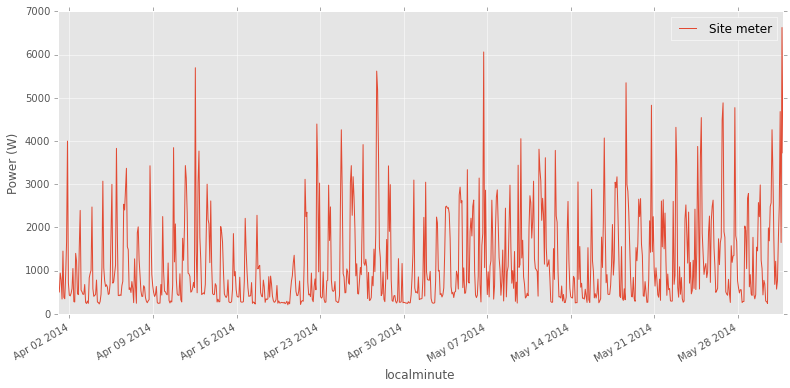

In [6]:
train.buildings[1].elec.mains().plot()

### Let's split data at April 30th

In [7]:
train.set_window(end="30-4-2014")
test.set_window(start="30-4-2014")

In [8]:
train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

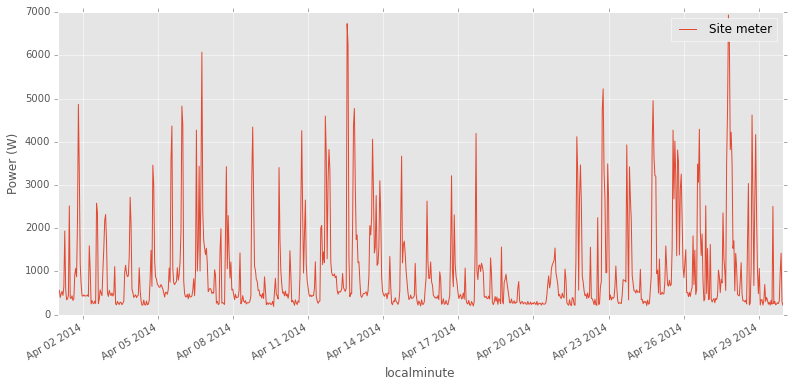

In [9]:
train_elec.mains().plot()

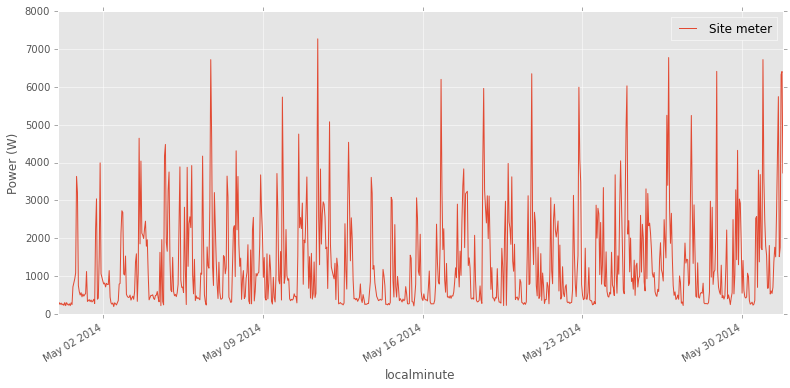

In [10]:
test_elec.mains().plot()

In [11]:
m = train_elec['fridge']

In [12]:
df_raw = m.load().next()

In [13]:
df_raw.head(10)

physical_quantity,power
type,active
localminute,
2014-04-01 00:00:00-05:00,112
2014-04-01 00:01:00-05:00,100
2014-04-01 00:02:00-05:00,4
2014-04-01 00:03:00-05:00,4
2014-04-01 00:04:00-05:00,4
2014-04-01 00:05:00-05:00,4
2014-04-01 00:06:00-05:00,4
2014-04-01 00:07:00-05:00,4


In [14]:
df_1_min = m.power_series(sample_period=60).next()

In [15]:
df_1_min.head()

localminute
2014-04-01 00:00:00-05:00    112
2014-04-01 00:01:00-05:00    100
2014-04-01 00:02:00-05:00      4
2014-04-01 00:03:00-05:00      4
2014-04-01 00:04:00-05:00      4
Freq: 60S, Name: (power, active), dtype: float64

## Selecting top-5 appliances

In [16]:
top_2_train_elec = train_elec.submeters().select_top_k(k=2)

15/15 ElecMeter(instance=16, building=1, dataset='WikiEnergy', appliances=[Appliance(type='appliance', instance=1)])

In [17]:
top_2_train_elec

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])
  ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])
)

## Training and disaggregation

### FHMM

Let us first train on raw data, no downsampling and see how much time it takes

In [18]:
import time

In [19]:
"""start=time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(top_5_train_elec)
end=time.time()
print end-start
"""

'start=time.time()\nfhmm = fhmm_exact.FHMM()\nfhmm.train(top_5_train_elec)\nend=time.time()\nprint end-start\n'

In [31]:
start=time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(top_2_train_elec, sample_period=60)
end=time.time()
print end-start

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])'
19.3935670853


In [20]:
test_mains_df = test_elec.mains().load().next()

In [33]:
fhmm.disaggregate_chunk(test_mains_df).head()

,"ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])","ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])"
localminute,,
2014-04-30 00:00:00-05:00,0,461
2014-04-30 00:01:00-05:00,0,461
2014-04-30 00:02:00-05:00,0,461
2014-04-30 00:03:00-05:00,0,461
2014-04-30 00:04:00-05:00,0,461


In [34]:
from nilmtk.disaggregate import CombinatorialOptimisation

In [35]:
co = CombinatorialOptimisation()

In [36]:
co.train(top_2_train_elec, sample_period=60)



Training model for submeter 'ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])'
Done training!


In [37]:
pred_df = co.disaggregate_chunk(test_mains_df)

Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])'
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])'


In [38]:
co.model

[{'states': array([   0,  252, 3399], dtype=int32),
  'training_metadata': ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])},
 {'states': array([   0,  791, 2204], dtype=int32),
  'training_metadata': ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])}]

In [39]:
co.model[0]['training_metadata']

ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])

In [40]:
[co.model[i]['training_metadata'] for i in pred_df.columns]

[ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)]),
 ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])]

In [41]:
pred_df.columns = [co.model[i]['training_metadata'] for i in pred_df.columns]

In [42]:
pred_df.head()

,"ElecMeter(instance=3, building=1, dataset='WikiEnergy', appliances=[Appliance(type='electric vehicle', instance=1)])","ElecMeter(instance=2, building=1, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])"
localminute,,
2014-04-30 00:00:00-05:00,252,0
2014-04-30 00:01:00-05:00,252,0
2014-04-30 00:02:00-05:00,252,0
2014-04-30 00:03:00-05:00,252,0
2014-04-30 00:04:00-05:00,252,0


In [21]:
from nilmtk.disaggregate import Hart85

In [22]:
h = Hart85()

In [23]:
h.train(train_elec.mains())

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [24]:
from nilmtk.feature_detectors.steady_states import find_steady_states_transients, find_steady_states
[_, transients] = find_steady_states(test_mains_df, h.cols, h.state_threshold, h.noise_level)

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [25]:
hart_pred_df = h.disaggregate_single_chunk(test_mains_df, {}, transients)

In [26]:
hart_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
localminute,,,,,,,,,,
2014-04-30 00:00:00-05:00,0,0,0,0,0,0,0,0,0,0
2014-04-30 00:01:00-05:00,0,0,0,0,0,0,0,0,0,0
2014-04-30 00:02:00-05:00,0,0,0,0,0,0,0,0,0,0
2014-04-30 00:03:00-05:00,120,0,0,0,0,0,0,0,0,0
2014-04-30 00:04:00-05:00,120,0,0,0,0,0,0,0,0,0


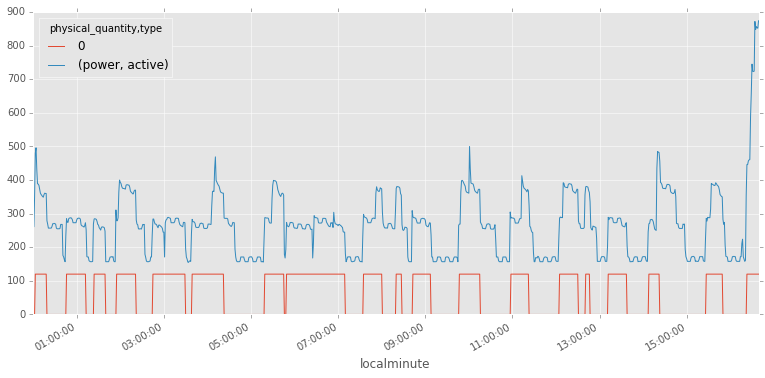

In [27]:
ax = hart_pred_df[[0]].head(1000).plot()
test_mains_df.head(1000).plot(ax=ax)

In [28]:
h.centroids.index.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [29]:
hart_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
localminute,,,,,,,,,,
2014-04-30 00:00:00-05:00,0,0,0,0,0,0,0,0,0,0
2014-04-30 00:01:00-05:00,0,0,0,0,0,0,0,0,0,0
2014-04-30 00:02:00-05:00,0,0,0,0,0,0,0,0,0,0
2014-04-30 00:03:00-05:00,120,0,0,0,0,0,0,0,0,0
2014-04-30 00:04:00-05:00,120,0,0,0,0,0,0,0,0,0


In [30]:
chunk = test_elec.mains().power_series().next()

In [31]:
cols = pd.MultiIndex.from_tuples([chunk.name])

In [32]:
cols

MultiIndex(levels=[[u'power'], [u'active']],
           labels=[[0], [0]])

In [33]:
meter = 0

In [34]:
df = hart_pred_df[[meter]]

In [35]:
df.columns = cols

In [36]:
df

,power
,active
localminute,
2014-04-30 00:00:00-05:00,0
2014-04-30 00:01:00-05:00,0
2014-04-30 00:02:00-05:00,0
2014-04-30 00:03:00-05:00,120
2014-04-30 00:04:00-05:00,120
2014-04-30 00:05:00-05:00,120
2014-04-30 00:06:00-05:00,120
2014-04-30 00:07:00-05:00,120


In [37]:
disag_filename = '/Users/nipunbatra/Desktop/test_hart.h5'
output = HDFDataStore(disag_filename, 'w')
h.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [38]:
disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

In [39]:
disag_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='Hart85_2015-07-10T21:21:06', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=0)])
  ElecMeter(instance=3, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=4, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=2)])
  ElecMeter(instance=5, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=3)])
  ElecMeter(instance=6, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=4)])
  ElecMeter(instance=7, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=5)])
  ElecMeter(instance=8, building=1, dataset='Hart85_2015-07-10T21:21:06', appliances=[Appliance(type='unknown', instance=6)]

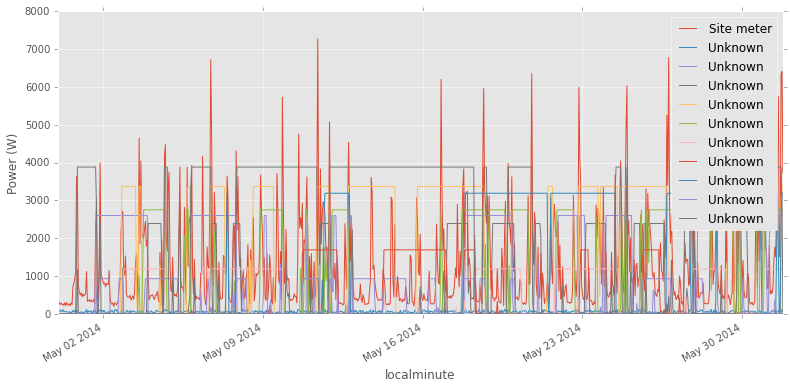

In [44]:
disag_elec.plot()

In [40]:
st = pd.HDFStore(disag_filename)

In [45]:
d = disag_elec[('unknown',0)].load().next()

In [46]:
d.tail()

,power
,active
localminute,
2014-05-31 18:54:00-05:00,120
2014-05-31 18:55:00-05:00,120
2014-05-31 18:56:00-05:00,120
2014-05-31 18:57:00-05:00,120
2014-05-31 18:58:00-05:00,0


In [48]:
hart_pred_df[[0]].tail()

,0
localminute,
2014-05-31 18:54:00-05:00,120
2014-05-31 18:55:00-05:00,120
2014-05-31 18:56:00-05:00,120
2014-05-31 18:57:00-05:00,120
2014-05-31 18:58:00-05:00,0


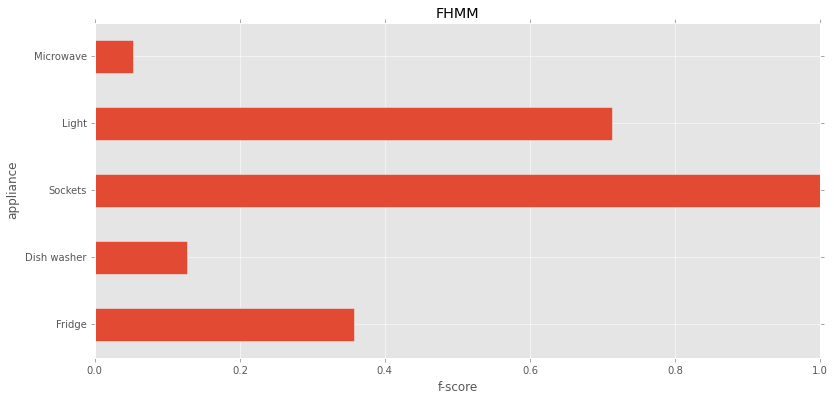

In [25]:
f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

In [17]:
# CSS styling
from IPython.core.display import display, HTML
display(HTML(open('static/styles.css', 'r').read()));